In [55]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import pandas as pd, numpy as np
import matplotlib as mpl
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import confusion_matrix,precision_score,recall_score,roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score,ConfusionMatrixDisplay
import joblib
from sklearn.inspection import permutation_importance
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore')
from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_classification
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier, RUSBoostClassifier
from imblearn.under_sampling import NearMiss
from sklearn.cluster import MiniBatchKMeans
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import CondensedNearestNeighbour  
from imblearn.under_sampling import EditedNearestNeighbours #把多分类改成二分类了
from imblearn.under_sampling import RepeatedEditedNearestNeighbours#把多分类改成二分类了
from imblearn.under_sampling import AllKNN
from imblearn.combine import SMOTEENN
from sklearn.metrics import matthews_corrcoef
import shap
from sklearn.preprocessing import StandardScaler



In [5]:
# mpl.rcParams['font.sans-serif']=['SimHei']
# mpl.rcParams['axes.unicode_minus']=False
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']


              precision    recall  f1-score   support

           0       0.67      0.09      0.17       381
           1       0.91      1.00      0.95      3605

    accuracy                           0.91      3986
   macro avg       0.79      0.54      0.56      3986
weighted avg       0.89      0.91      0.88      3986

Matthews Correlation Coefficient: 0.2276202316369522
Random Forest选择的重要特征: ['Sum_OSI' 'Sum_CSDMHS' 'Sum_IIS' 'Sum_STPQawt' 'Sum_STPQ' 'Sum_PSQI'
 'Sum_STPQil' 'Sum_STPQpost' 'Sum_STPQoc' 'Sum_LSS' 'Sum_STPQai'
 'Sum_PBSMHS' 'Sum_WFCS' 'Sum_STPQpe' 'Sum_PCQ' 'Sum_STPQjs' 'Sum_MBIGS'
 'Sum_STPQsc' 'Sum_STPQlt' 'Sum_STPQpv' 'Sum_MHLQ' 'Sum_STPQea'
 'Sum_Background']
Precision: 88.88%Recall: 90.89%


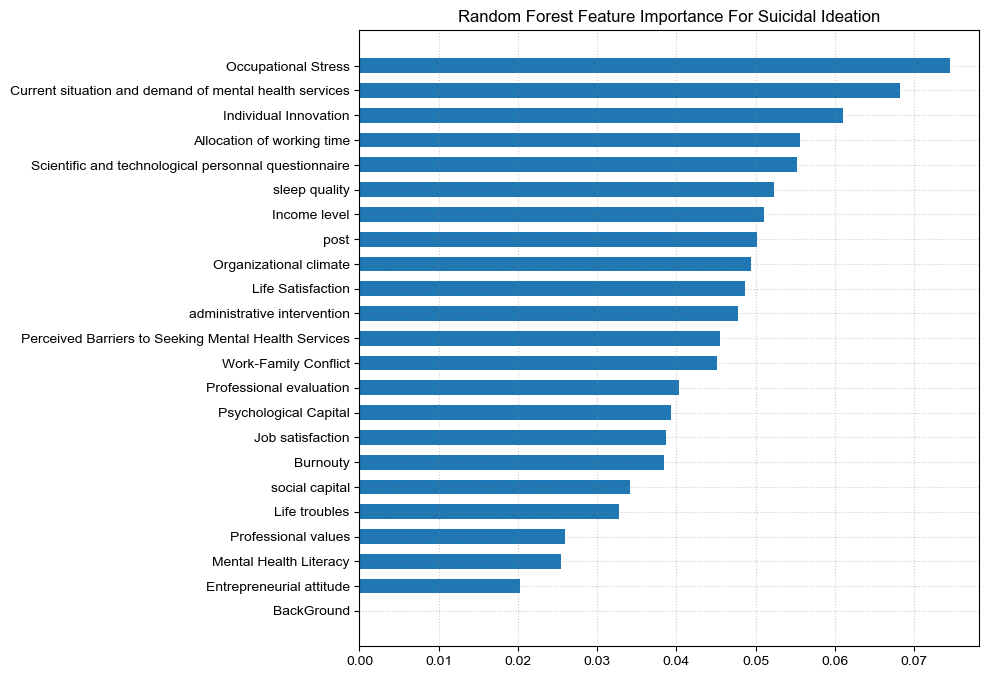

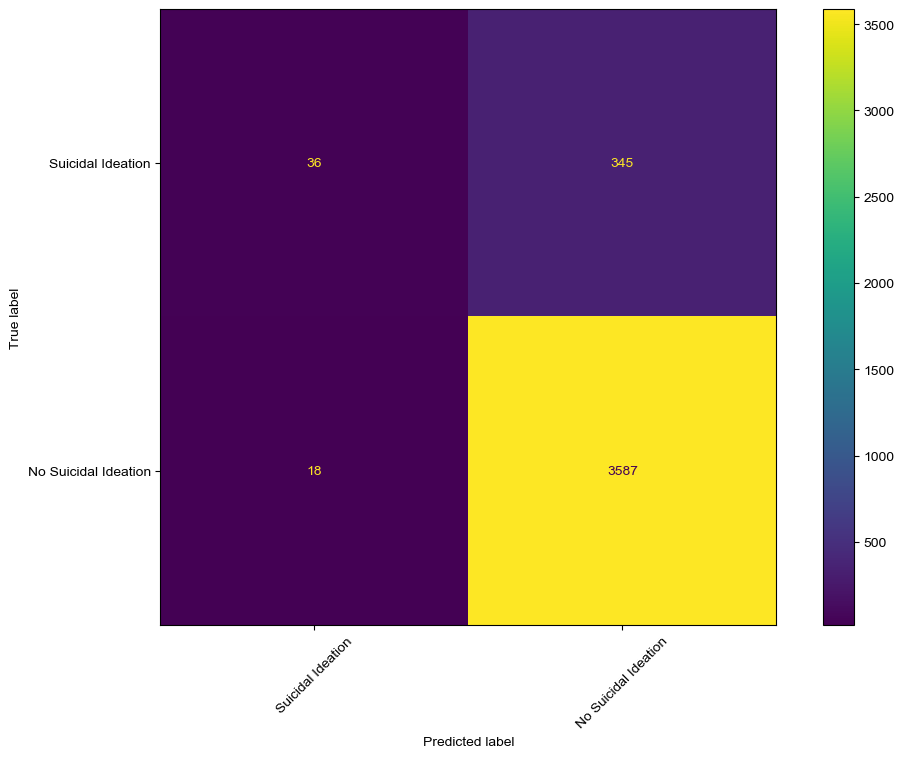

In [60]:
# fpath = r"/Users/wangxiaoyan/Documents/wy/论文/git/scientific-worker-mental-health/data/all/2017科技人员心理健康-按量表分组计算后数据.csv"
fpath = r"/Users/wangxiaoyan/Documents/wy/论文/git/scientific-worker-mental-health/data/all/2017科技人员心理健康-问卷分组计算后数据.csv"


Dataset = pd.read_csv(fpath)
number = 40
Dataset = Dataset.drop('depression', axis=1)
Dataset = Dataset.drop('anxiety', axis=1)

y = Dataset['suicide']
x = Dataset.drop('suicide', axis=1)

feature_names = np.array(x.columns)

names = x.columns
names = list(names)
key = list(range(0, len(names)))
names_dict = dict(zip(key, names))
names_dicts = pd.DataFrame([names_dict])
random_state = 42
# cc = SMOTEENN(random_state=42)
# X_res, y_res = cc.fit_resample(x, y)
# print(Counter(y_res))
scaler = StandardScaler()
X_scaled = scaler.fit_transform(x)
x_train, x_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=random_state)

bbc = RandomForestClassifier(n_estimators=100,random_state=random_state)

bbc.fit(x_train, y_train)
# import warnings
warnings.filterwarnings('ignore')
# Evaluate the model on the testing data
y_pred = bbc.predict(x_test)
precision = precision_score(y_test, y_pred,average='weighted')
recall = recall_score(y_test, y_pred,average='weighted')

# evaluate the performance of the model
score = bbc.score(x_test, y_pred)
report = classification_report(y_test, y_pred)
print(report)
mcc = matthews_corrcoef(y_test, y_pred)
print("Matthews Correlation Coefficient:", mcc)


rf_feature_important = bbc.feature_importances_
rf_x_score = np.sort(rf_feature_important)[::-1]
rf_rank_idx  = np.argsort(rf_feature_important)[::-1]
rf_selected_rank_idx = rf_rank_idx[:number]
rf_selected_rank_names = names_dicts.loc[:, rf_selected_rank_idx]
rf_label = rf_selected_rank_names.values[0, :]
name_mapping = {
    'Sum_OSI':'Occupational Stress',
    'Sum_IIS':'Individual Innovation',
    'Sum_STPQea':'Entrepreneurial attitude',
    'Sum_LSS':'Life Satisfaction',
    'Sum_PCQ':'Psychological Capital',
    'Sum_STPQsc':'social capital',
    'Sum_STPQlt':'Life troubles',
    'Sum_STPQai':'administrative intervention',
    'Sum_STPQil':'Income level',
    'Sum_WFCS':'Work-Family Conflict',
    'Sum_PBSMHS':'Perceived Barriers to Seeking Mental Health Services',
    'Sum_STPQ':'Scientific and technological personnal questionnaire',
    'Sum_STPQawt':'Allocation of working time',
    'Sum_STPQpost':'post',
    'Sum_STPQpe':'Professional evaluation',
    'Sum_PSQI':'sleep quality',
    'Sum_STPQoc':'Organizational climate',
    'Sum_STPQpv':'Professional values',
    'Sum_MHLQ':'Mental Health Literacy',
    'Sum_CSDMHS':'Current situation and demand of mental health services',
    'Sum_STPQjs':'Job satisfaction',
    'Sum_MBIGS':'Burnouty',
    'Sum_Background': "BackGround"
}
print("Random Forest选择的重要特征:",rf_label)
rf_new_label = [name_mapping.get(name, name) for name in rf_label]

print("Precision: {:.2f}%".format(precision * 100) + "Recall: {:.2f}%".format(recall * 100))
plt.figure(figsize=(8, 8))
plt.barh(rf_new_label[::-1], rf_x_score[:number][::-1], 0.6, align='center')
plt.grid(ls=':', color='gray', alpha=0.4)
plt.title("Random Forest Feature Importance For Suicidal Ideation")
plt.savefig("前"+str(number)+"名特征")
plt.show()


label_dict = {
    0: 'Suicidal Ideation',
    1: 'No Suicidal Ideation'
}
y_test_text = [label_dict[label] for label in y_test]
y_pred_text = [label_dict[label] for label in y_pred]
cm_text = confusion_matrix(y_test_text, y_pred_text, labels=list(label_dict.values()))

disp_text = ConfusionMatrixDisplay(confusion_matrix=cm_text, display_labels=list(label_dict.values()))
disp_text.plot()
plt.xticks(rotation=45)
plt.show()

# plt.rcParams["figure.figsize"] = (12, 8)

# # 使用内联模式显示图像
# %matplotlib inline

# explainer = shap.TreeExplainer(bbc)
# shap_values = explainer.shap_values(x_train)
# # 调整图像大小
# plt.figure(figsize=(8, 8))

# # 绘制SHAP总结图
# shap.summary_plot(shap_values, x_train,max_display=20)

# # 保存SHAP总结图
# # plt.savefig('shap_summary_plot.png', bbox_inches='tight')

# # 关闭图像，以防在之后的代码中再次显示
# plt.close()
    
# sorted_feature_names = [x_train.columns[i] for i in shap.summary_plot(shap_values, x_train, plot=False)]

# # 输出前N个最重要的特征
# top_n_features = 20  # 可以根据你的需求调整此值

# print("\nSHAP总结图中的前N个最重要的特征：")
# for feature_name in sorted_feature_names[:top_n_features]:
#     print(feature_name)


原始数据集类别分布： Counter({0: 6535, 1: 5725, 2: 788, 3: 236})
              precision    recall  f1-score   support

           0       0.77      0.76      0.76      1964
           1       0.63      0.74      0.68      1720
           2       0.42      0.02      0.04       230
           3       0.90      0.12      0.22        72

    accuracy                           0.70      3986
   macro avg       0.68      0.41      0.43      3986
weighted avg       0.69      0.70      0.68      3986

Random Forest选择的重要特征: ['Sum_OSI' 'Sum_WFCS' 'Sum_LSS' 'Sum_STPQ' 'Sum_STPQawt' 'Sum_MBIGS'
 'Sum_PSQI' 'Sum_PBSMHS' 'Sum_PCQ' 'Sum_STPQpost' 'Sum_STPQoc'
 'Sum_CSDMHS' 'Sum_STPQil' 'Sum_STPQai' 'Sum_IIS' 'Sum_STPQpe'
 'Sum_STPQjs' 'Sum_STPQlt' 'Sum_STPQsc' 'Sum_STPQpv' 'Sum_MHLQ'
 'Sum_STPQea' 'Sum_Background']
Precision: 69.15%Recall: 69.87%


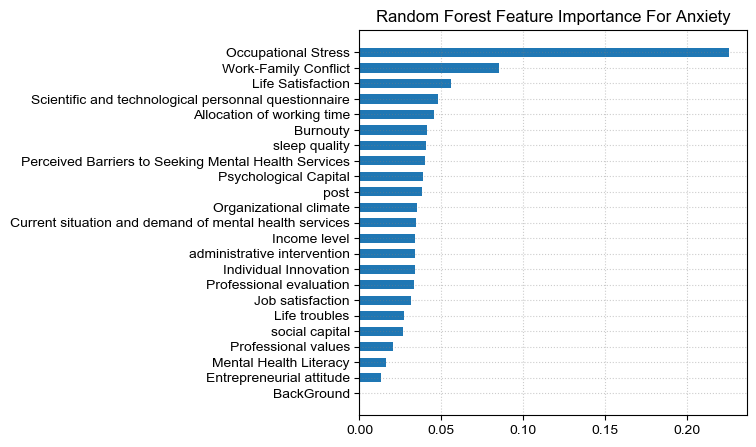

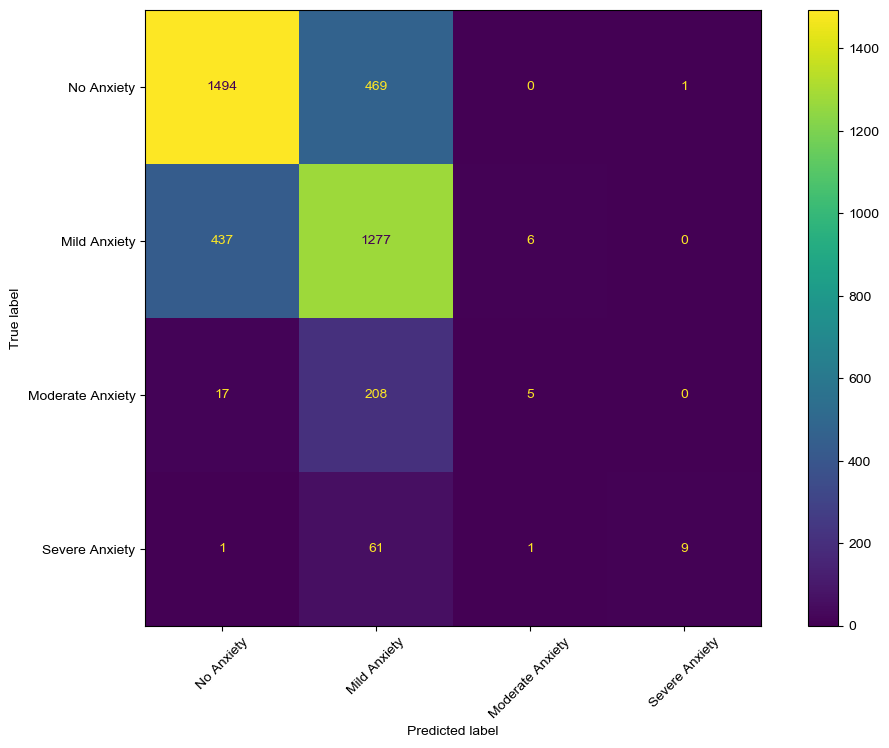

In [64]:
fpath = r"/Users/wangxiaoyan/Documents/wy/论文/git/scientific-worker-mental-health/data/all/2017科技人员心理健康-问卷分组计算后数据.csv"

Dataset = pd.read_csv(fpath)
number = 23
Dataset = Dataset.drop('depression', axis=1)
Dataset = Dataset.drop('suicide', axis=1)
y = Dataset['anxiety']
x = Dataset.drop('anxiety', axis=1)
print('原始数据集类别分布：', Counter(y))
feature_names = np.array(x.columns)

names = x.columns
names = list(names)
key = list(range(0, len(names)))
names_dict = dict(zip(key, names))
names_dicts = pd.DataFrame([names_dict])
random_state = 42
# cc = SMOTEENN(random_state=42)
# X_res, y_res = cc.fit_resample(x, y)
# print(Counter(y_res))
scaler = StandardScaler()
X_scaled = scaler.fit_transform(x)
x_train, x_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=random_state)

bbc = RandomForestClassifier(n_estimators=200,random_state=random_state,min_samples_split=10,min_samples_leaf=1)

bbc.fit(x_train, y_train)
# import warnings
warnings.filterwarnings('ignore')
# Evaluate the model on the testing data
y_pred = bbc.predict(x_test)
precision = precision_score(y_test, y_pred,average='weighted')
recall = recall_score(y_test, y_pred,average='weighted')

# evaluate the performance of the model
score = bbc.score(x_test, y_pred)
report = classification_report(y_test, y_pred)
print(report)

rf_feature_important = bbc.feature_importances_
rf_x_score = np.sort(rf_feature_important)[::-1]
rf_rank_idx  = np.argsort(rf_feature_important)[::-1]
rf_selected_rank_idx = rf_rank_idx[:number]
rf_selected_rank_names = names_dicts.loc[:, rf_selected_rank_idx]
rf_label = rf_selected_rank_names.values[0, :]
name_mapping = {
    'Sum_OSI':'Occupational Stress',
    'Sum_IIS':'Individual Innovation',
    'Sum_STPQea':'Entrepreneurial attitude',
    'Sum_LSS':'Life Satisfaction',
    'Sum_PCQ':'Psychological Capital',
    'Sum_STPQsc':'social capital',
    'Sum_STPQlt':'Life troubles',
    'Sum_STPQai':'administrative intervention',
    'Sum_STPQil':'Income level',
    'Sum_WFCS':'Work-Family Conflict',
    'Sum_PBSMHS':'Perceived Barriers to Seeking Mental Health Services',
    'Sum_STPQ':'Scientific and technological personnal questionnaire',
    'Sum_STPQawt':'Allocation of working time',
    'Sum_STPQpost':'post',
    'Sum_STPQpe':'Professional evaluation',
    'Sum_PSQI':'sleep quality',
    'Sum_STPQoc':'Organizational climate',
    'Sum_STPQpv':'Professional values',
    'Sum_MHLQ':'Mental Health Literacy',
    'Sum_CSDMHS':'Current situation and demand of mental health services',
    'Sum_STPQjs':'Job satisfaction',
    'Sum_MBIGS':'Burnouty',
    'Sum_Background': "BackGround"

}
print("Random Forest选择的重要特征:",rf_label)
rf_new_label = [name_mapping.get(name, name) for name in rf_label]

# 随机森林可视化
print("Precision: {:.2f}%".format(precision * 100) + "Recall: {:.2f}%".format(recall * 100))
plt.figure(figsize=(5, 5))
plt.barh(rf_new_label[::-1], rf_x_score[:number][::-1], 0.6, align='center')
plt.grid(ls=':', color='gray', alpha=0.4)
plt.title("Random Forest Feature Importance For Anxiety")
plt.savefig("前"+str(number)+"名特征")
plt.show()
label_dict = {
    0: 'No Anxiety',
    1: 'Mild Anxiety',
    2: 'Moderate Anxiety',
    3: 'Severe Anxiety'
}
y_test_text = [label_dict[label] for label in y_test]
y_pred_text = [label_dict[label] for label in y_pred]
cm_text = confusion_matrix(y_test_text, y_pred_text, labels=list(label_dict.values()))

disp_text = ConfusionMatrixDisplay(confusion_matrix=cm_text, display_labels=list(label_dict.values()))
disp_text.plot()
plt.xticks(rotation=45)
plt.show()




原始数据集类别分布： Counter({0: 10920, 1: 2077, 2: 287})
              precision    recall  f1-score   support

           0       0.84      0.99      0.91      3291
           1       0.51      0.10      0.17       613
           2       0.75      0.07      0.13        82

    accuracy                           0.83      3986
   macro avg       0.70      0.39      0.41      3986
weighted avg       0.79      0.83      0.78      3986

Random Forest选择的重要特征: ['Sum_OSI' 'Sum_WFCS' 'Sum_STPQawt' 'Sum_STPQ' 'Sum_PSQI' 'Sum_LSS'
 'Sum_CSDMHS' 'Sum_STPQai' 'Sum_PBSMHS' 'Sum_MBIGS' 'Sum_STPQpost'
 'Sum_STPQoc' 'Sum_STPQil' 'Sum_IIS' 'Sum_STPQpe' 'Sum_PCQ' 'Sum_STPQjs'
 'Sum_STPQlt' 'Sum_STPQsc' 'Sum_STPQpv' 'Sum_MHLQ' 'Sum_STPQea'
 'Sum_Background']
Precision: 78.95%Recall: 83.22%


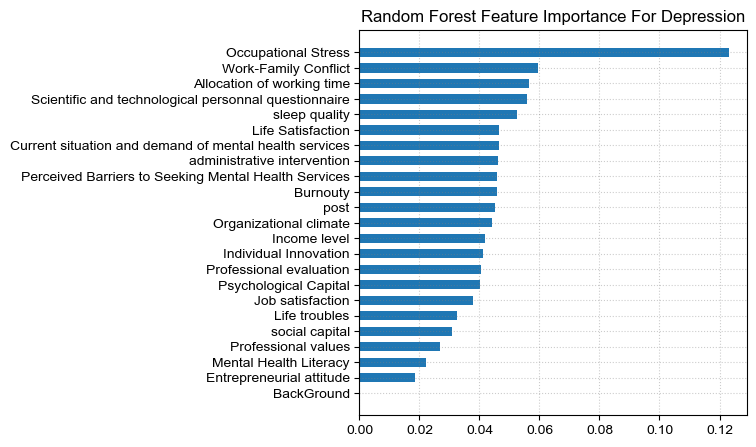

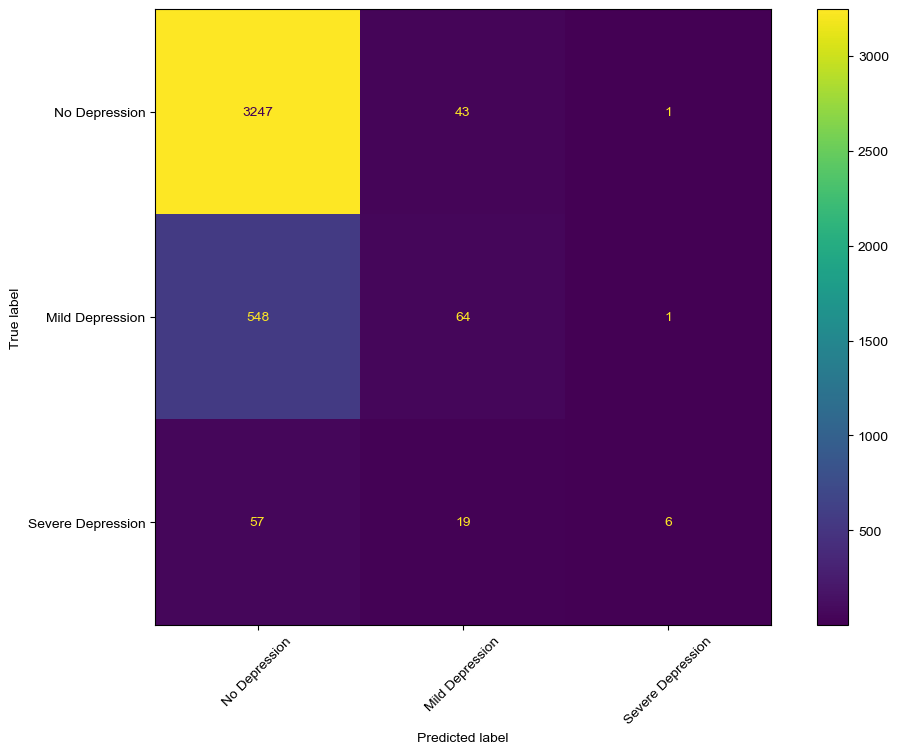

In [57]:
# fpath = r"/Users/wangxiaoyan/Documents/wy/论文/git/scientific-worker-mental-health/data/all/2017科技人员心理健康-除背景问卷-问卷分组计算后数据.csv"
fpath = r"/Users/wangxiaoyan/Documents/wy/论文/git/scientific-worker-mental-health/data/all/2017科技人员心理健康-问卷分组计算后数据.csv"

Dataset = pd.read_csv(fpath)
number = 30
Dataset = Dataset.drop('anxiety', axis=1)
Dataset = Dataset.drop('suicide', axis=1)

y = Dataset['depression']
x = Dataset.drop('depression', axis=1)

print('原始数据集类别分布：', Counter(y))

feature_names = np.array(x.columns)

names = x.columns
names = list(names)
key = list(range(0, len(names)))
names_dict = dict(zip(key, names))
names_dicts = pd.DataFrame([names_dict])
random_state = 42
# cc = SMOTEENN(random_state=42)
# X_res, y_res = cc.fit_resample(x, y)
# print(Counter(y_res))
scaler = StandardScaler()
X_scaled = scaler.fit_transform(x)
x_train, x_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=random_state)

bbc = RandomForestClassifier(n_estimators=100,random_state=random_state)

bbc.fit(x_train, y_train)
# import warnings
warnings.filterwarnings('ignore')
# Evaluate the model on the testing data
y_pred = bbc.predict(x_test)
precision = precision_score(y_test, y_pred,average='weighted')
recall = recall_score(y_test, y_pred,average='weighted')

# evaluate the performance of the model
score = bbc.score(x_test, y_pred)
report = classification_report(y_test, y_pred)
print(report)


rf_feature_important = bbc.feature_importances_
rf_x_score = np.sort(rf_feature_important)[::-1]
rf_rank_idx  = np.argsort(rf_feature_important)[::-1]
rf_selected_rank_idx = rf_rank_idx[:number]
rf_selected_rank_names = names_dicts.loc[:, rf_selected_rank_idx]
rf_label = rf_selected_rank_names.values[0, :]
name_mapping = {
    'Sum_OSI':'Occupational Stress',
    'Sum_IIS':'Individual Innovation',
    'Sum_STPQea':'Entrepreneurial attitude',
    'Sum_LSS':'Life Satisfaction',
    'Sum_PCQ':'Psychological Capital',
    'Sum_STPQsc':'social capital',
    'Sum_STPQlt':'Life troubles',
    'Sum_STPQai':'administrative intervention',
    'Sum_STPQil':'Income level',
    'Sum_WFCS':'Work-Family Conflict',
    'Sum_PBSMHS':'Perceived Barriers to Seeking Mental Health Services',
    'Sum_STPQ':'Scientific and technological personnal questionnaire',
    'Sum_STPQawt':'Allocation of working time',
    'Sum_STPQpost':'post',
    'Sum_STPQpe':'Professional evaluation',
    'Sum_PSQI':'sleep quality',
    'Sum_STPQoc':'Organizational climate',
    'Sum_STPQpv':'Professional values',
    'Sum_MHLQ':'Mental Health Literacy',
    'Sum_CSDMHS':'Current situation and demand of mental health services',
    'Sum_STPQjs':'Job satisfaction',
    'Sum_MBIGS':'Burnouty',
    'Sum_Background':'BackGround'
}
print("Random Forest选择的重要特征:",rf_label)
rf_new_label = [name_mapping.get(name, name) for name in rf_label]

# 随机森林可视化
print("Precision: {:.2f}%".format(precision * 100) + "Recall: {:.2f}%".format(recall * 100))
plt.figure(figsize=(5, 5))
plt.barh(rf_new_label[::-1], rf_x_score[:number][::-1], 0.6, align='center')
plt.grid(ls=':', color='gray', alpha=0.4)
plt.title("Random Forest Feature Importance For Depression")
plt.savefig("前"+str(number)+"名特征")
plt.show()

label_dict = {
    0: 'No Depression',
    1: 'Mild Depression',
    2: 'Severe Depression'
}
y_test_text = [label_dict[label] for label in y_test]
y_pred_text = [label_dict[label] for label in y_pred]
cm_text = confusion_matrix(y_test_text, y_pred_text, labels=list(label_dict.values()))

disp_text = ConfusionMatrixDisplay(confusion_matrix=cm_text, display_labels=list(label_dict.values()))
disp_text.plot()
plt.xticks(rotation=45)
plt.show()
